In [2]:
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import * 
from BootstrappedNonparametrics.nonparametrics import *
import os
import math
import time
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import scipy.io as sio
from sklearn import mixture
from sklearn.neighbors import NearestNeighbors

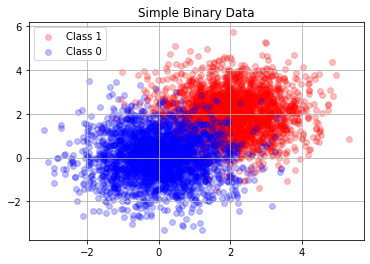

In [3]:
from sklearn.neighbors import KNeighborsClassifier
# from slkearn
x0, x1, labels = gen_simple_binary_data(N = 2500, mu_y = 2 * np.ones([1, 2]), ndims = 2)
xdata = np.vstack([x0, x1])
# print(labels.shape)
# print(xdata.shape)
# plt.figure()
# plt.plot(a[:, 0], a[:, 1], ')
plot_2d_dataset(xdata, labels, 'Simple Binary Data')

neigh = NearestNeighbors(n_neighbors=3)
neigh = neigh.fit(xdata)


In [4]:
'''
functions for evaluating the kde objects
'''

def fit_kde(xinput, bw, kernel = 'gaussian'):
    '''
    xinput - the input data to run the kde on. [nsamples x nfeatures]
    bw - kde bandwidth
    '''
    
    return KernelDensity(kernel=kernel, bandwidth=bw).fit(xinput.reshape(-1, 1))

def evaluate_kde_proba(xdata, kdeobject):
    '''
    returns the probabilites from the kde object on xdata
    '''
    if len(xdata.shape)<2:
        _xdata = xdata.reshape(-1, 1)
    else:
        _xdata = xdata
        
    probas = np.exp(kdeobject.score_samples(_xdata))
    return probas     

def compute_kde_c1_posterior(c0kde_object, c1kde_object, xinput):
    '''
    Given the c0kde and the c1kde this function predicts the probability on unseen data
    
    c0kde object - computes p(y=0|x), must be fit already trained
    c1kde object - computes p(y=1|x), must be fit already trained
    
    xinput - [nsamples x nfeatures]
    
    output of this function
    - a numpy array [nsamples x 1]
    '''
    if len(xinput.shape)<2:
        _xdata = xinput.reshape(-1, 1)
    else:
        _xdata = xinput
    p_y0 = evaluate_kde_proba(_xdata, c0kde_object)
    p_y1 = evaluate_kde_proba(_xdata, c1kde_object)
    p_y1_x = p_y1/(p_y0 + p_y1)
    return p_y1_x
    


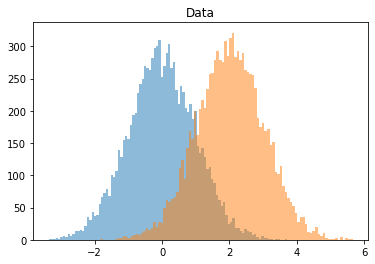

In [5]:
def gen_1d_distribution(nclass1, nclass2, xmin=0, xmax=1, offset=.5):
    pass

# c1 = np.random.uniform(0, 1, (10000,1))
# c2 = np.random.uniform(0, 1, (10000,1)) + .5
c1 = np.random.randn(10000,1)
c2 = np.random.randn(10000,1) + 2
xdata = np.concatenate([c1, c2])
ydata = np.concatenate([np.zeros_like(c1), np.ones_like(c2)])
plt.title('Data')
plt.hist(c1, alpha=.5, bins=100)
plt.hist(c2, alpha=.5, bins=100)
print()

In [6]:
'''
Simple linear regression example
'''
from sklearn.neighbors import KernelDensity
from active_trainer import *

xunif, unifinds = uniform_sample(xdata, 1000)
yunif = ydata[unifinds]
kde = KernelDensity(kernel='gaussian').fit(xunif)

xunlab = np.delete(xdata, unifinds, axis=0)
yunlab = np.delete(ydata, unifinds, axis=0)

In [7]:
c0kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit(xunif[yunif==0].reshape(-1, 1))
c1kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit(xunif[yunif==1].reshape(-1, 1))

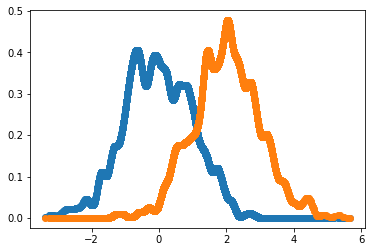

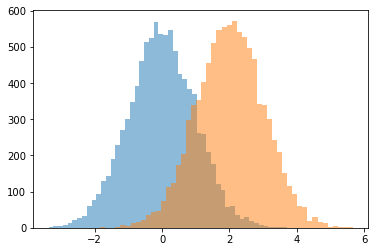

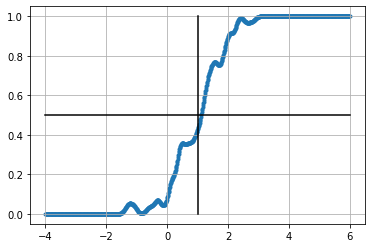

In [8]:
c0score = c0kde.score_samples(xunlab)
c1score = c1kde.score_samples(xunlab)

c0density = np.exp(c0score)
c1density = np.exp(c1score)
plt.scatter(xunlab, c0density)
plt.scatter(xunlab, c1density)

plt.figure()
plt.hist(xunlab[yunlab==0], alpha=.5, bins=50)
plt.hist(xunlab[yunlab==1], alpha=.5, bins=50)

plt.figure()
xrange = np.linspace(-4, 6, 1000).reshape(-1, 1)
ypost = compute_kde_c1_posterior(c0kde, c1kde, xrange)
plt.scatter(xrange, ypost, marker='.')
plt.plot([-4, 6], [.5, .5], 'k')
plt.plot([1, 1], [0, 1], 'k')
plt.grid()

In [9]:
'''
Functions for the data generating processes
'''
def posterior_pdf2(xinput):
    '''
    xinput - [nsamples x nfeatures], the x value for the data 
    youtput - returns the probability that y=1
    '''
    assert not any(xinput>1) and not any(xinput<0), "This posterior function expects x values ONLY in the range 0<x<1"
    
    youtput = np.zeros((xinput.shape[0], 1))
    range1 = xinput<.2
    range2 = np.logical_and(xinput>=.20, xinput<=.6)
    range3 = xinput>.6
    
    youtput[range1] = .125 * np.sin(200 * xinput[range1]+1) + .75
    youtput[range2] = .0625 * np.sin(20 * xinput[range2] ) + .75
    youtput[range3] = .5
    return youtput

def assign_labels(xinput, yposterior):
    
    ylabels = np.zeros_like(yposterior)
    for ii, (xsamp, posteriorval) in enumerate(zip(xinput, yposterior)):
        
        ylabels[ii] = float(np.random.rand()<posteriorval)
    return ylabels

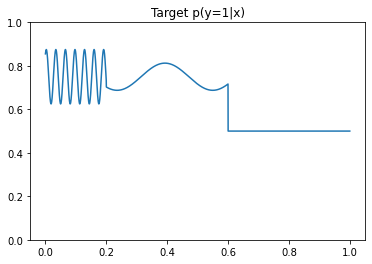

In [11]:
''' Train data '''

nrange = 5000
ntrain = 20000

xrange = np.linspace(0, 1, nrange).reshape(-1, 1)
xtrain = np.tile(xrange, int(ntrain/nrange)).reshape(-1, 1)
tr_post = posterior_pdf2(xtrain)
ytrain = assign_labels(xinput=xtrain, yposterior=tr_post)

plt.plot(xtrain, tr_post)
plt.ylim([0,1])
plt.title('Target p(y=1|x)')

tr_sfmx_probas = np.array([tr_post.ravel(), 1-tr_post.ravel()]).T
sampling_distr = get_sampling_distributions(xtrain, tr_sfmx_probas, k=1000)


''' Test dataset'''
ntest = 1000
xtest = np.linspace(0,1, ntest).reshape(-1,1)  
te_post = posterior_pdf2(xtest)
te_sfmx_probas =  np.array([te_post.ravel(), 1-te_post.ravel()]).T
ytest = assign_labels(xinput=xtest, yposterior=te_post)
# plt.xlim([0,.2])


In [25]:
.shape

(20000, 2)

In [ ]:
print(te_sfmx_probas.shape)
print(pred_te_sfmx.shape)

Test acc:	 0.656686
Test EPE:	 0.1367276608657156
Test Xent:	 inf


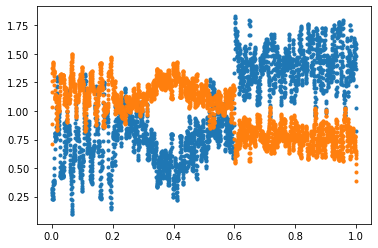

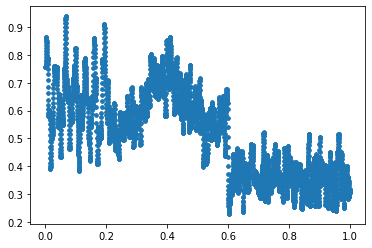

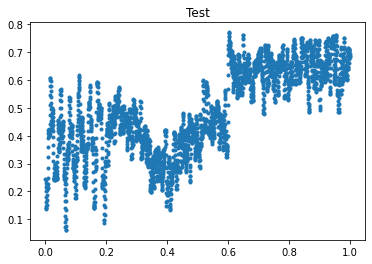

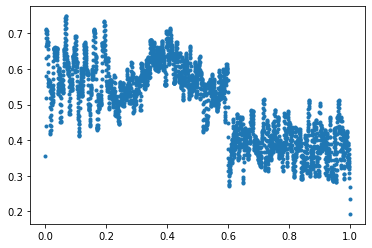

In [31]:
'''

Period is .003
'''

c0_kde = fit_kde(xtrain[ytrain==0], bw=.001)
c1_kde = fit_kde(xtrain[ytrain==1], bw=.001)
# fullkde = fit_kde(xtrain, bw=.001)
x0samps = xtrain[ytrain==0]
x1samps = xtrain[ytrain==1]

xrange = np.linspace(0,1, 3000)
c0prob = evaluate_kde_proba(xrange, c0_kde)
c1prob = evaluate_kde_proba(xrange, c1_kde)
# fullprob = evaluate_kde_proba(xrange, fullkde)

ypost = compute_kde_c1_posterior(c0_kde, c1_kde, xtrain)
yrangepost = compute_kde_c1_posterior(c0_kde, c1_kde, xrange)

plt.scatter(xrange, c0prob, marker='.')
plt.scatter(xrange, c1prob, marker='.')
# plt.scatter(xrange, fullprob, marker='.')
plt.figure()
plt.scatter(xtrain, ypost, marker='.')
plt.figure()
plt.title('Test')
plt.scatter(xrange, yrangepost*(c0prob/c1prob), marker='.')

plt.figure()
plt.scatter(xrange, c1prob*.5, marker='.')
# plt.figure(xtrain, ypost)
pred_test_probas = evaluate_kde_proba(xtest, c1_kde)
pred_train_probas = evaluate_kde_proba(xtrain, c1_kde)


pred_train_labels = np.ndarray.astype(pred_train_probas>=.5, 'float')
pred_test_labels = np.ndarray.astype(pred_test_probas>=.5, 'float')

pred_tr_sfmx = np.array([pred_train_probas.ravel(), 1-pred_train_probas.ravel()]).T
pred_te_sfmx =  np.array([pred_test_probas.ravel(), 1-pred_test_probas.ravel()]).T

test_teacher_xent = calc_crossentropy(te_sfmx_probas, pred_te_sfmx).mean()

train_acc = accuracy(yhat=pred_train_labels, y=ytrain) 
test_acc = accuracy(yhat=pred_test_labels, y=ytest)

train_epe = np.mean((pred_train_probas - tr_sfmx_probas[:, 0]) ** 2)
test_epe = np.mean((pred_test_probas - te_sfmx_probas[:, 0]) ** 2)
print('Test acc:\t', test_acc)
print('Test EPE:\t', test_epe)
print('Test Xent:\t', test_teacher_xent)
        
        

In [ ]:
plt.scatter()

In [10]:
print(sampling_distr.keys())
sampling_methods = ['variance', 'jsd', 'lipschitz', 'kldiv', 'entropy', 'xent']
sampling_names = {'variance':'Variance', 'jsd':'JS-Divergence', 'kldiv':'KL-Div', 'lipschitz':'Lipschitz', 'entropy':'Entropy', 'xent':'Cross Entropy'}

dict_keys(['variance', 'xent', 'jsd', 'kldiv', 'entropy', 'lipschitz'])


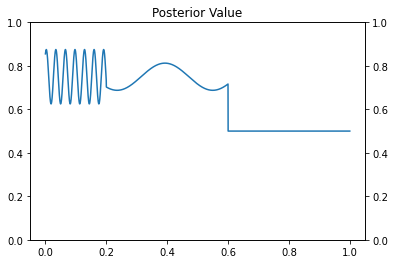

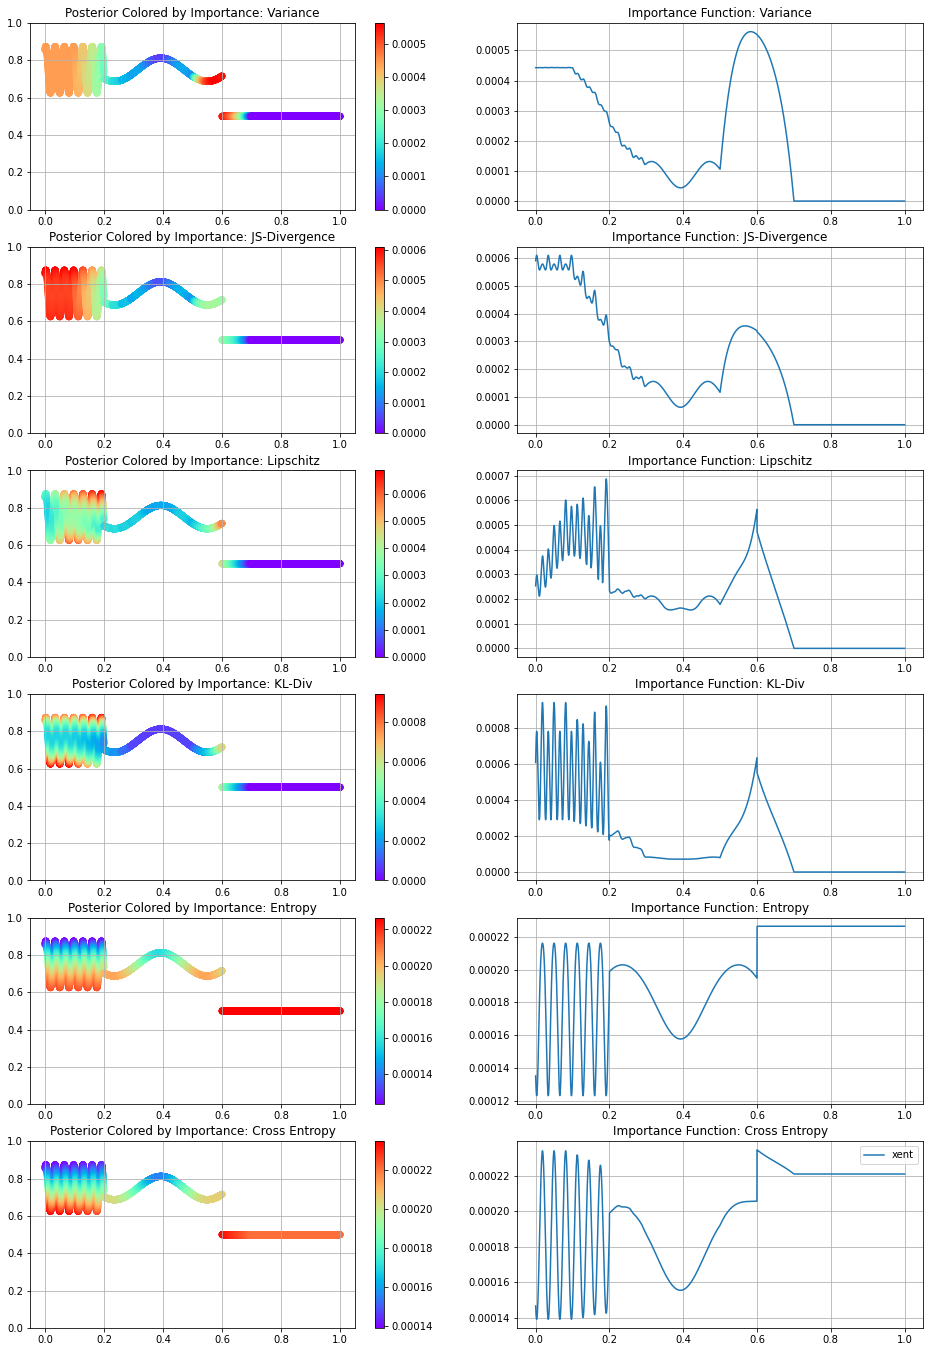

In [11]:
fig, ax = plt.subplots()
ax.plot(xtrain, tr_post)
ax.set_ylim([0,1])
ax.set_title('Posterior Value')
ax2 = ax.twinx()

plot_index = 0
num_methods = len(sampling_distr.keys())

plt.figure(figsize=(16, 4 * num_methods))
for ii, key in enumerate(sampling_methods):
    plt.subplot(num_methods, 2 , plot_index+1)
    wts = sampling_distr[key]
    sampling_pdf = wts/sum(wts)
    plt.scatter(xtrain, tr_post, c=sampling_pdf, label=key, cmap='rainbow')
    plt.title('Posterior Colored by Importance: %s' % sampling_names[key])
    plt.colorbar()
    plt.grid()
    plt.ylim([0,1])

    plt.subplot(num_methods, 2 , plot_index+2)
    plt.plot(xtrain, sampling_pdf, label=key)
    plt.title('Importance Function: %s' % sampling_names[key])
    plt.grid()

    plot_index+=2
    
plt.legend()


In [12]:
from scipy.special import rel_entr
from scipy.stats import entropy

In [14]:
import tqdm 
'''
function arguments
'''

#---------------------------------------
xtrain = xtrain
ytrain = ytrain
xtest = xtest
ytest = ytest
tr_sfmx = tr_sfmx_probas
te_sfmx = te_sfmx_probas
BUDGET=2000
nseed=25
nquery=25
sample_weights = sampling_distr['variance']/sum(sampling_distr['variance'])
uniform_frac=0.
MC_ITERS = 10
#---------------------------------------
active_accs = []
active_epes = []
active_label_xents = []
active_teacher_xents = []
stop=False
for MC in tqdm.tqdm(range(MC_ITERS)):
    sampling_weights = np.copy(sample_weights).ravel()
    xseed, seed_inds = uniform_sample(xtrain, nsample=nseed)
    
    active_sampsize = []
    active_acc = []
    active_epe = []
    active_label_xent = []
    active_teacher_xent = []
    
    selected_inds = seed_inds #the inital selected indices are only the seeded indices
    
    while len(selected_inds) < BUDGET:
        
        xselected = xtrain[selected_inds]
        yselected = ytrain[selected_inds]
        
        xstage1 = xselected
        ystage1 = yselected
        
#         mu = np.mean(xstage1, axis=0)
#         std = np.std(xstage1, axis=0)
#         xstage1 = (xstage1 - mu)/std
        
        
        c0_kde = fit_kde(xstage1[ystage1==0], bw=.001)
        c1_kde = fit_kde(xstage1[ystage1==1], bw=.001)
        
#         _xtest = (xtest - mu)/std
        # KDE Classifier
        pred_train_probas = compute_kde_c1_posterior(c0_kde, c1_kde, xstage1)
        pred_test_probas = compute_kde_c1_posterior(c0_kde, c1_kde, xtest)
        pred_train_labels = np.ndarray.astype(pred_test_probas>=.5, 'float')
        pred_test_labels = np.ndarray.astype(pred_train_probas>=.5, 'float')
        
        pred_tr_sfmx = np.array([pred_train_probas.ravel(), 1-pred_train_probas.ravel()]).T
        pred_te_sfmx = np.array([pred_test_probas.ravel(), 1-pred_test_probas.ravel()]).T        

        
#         _tr_acc = evaluate_classifier(classifier, _xstage1, ystage1, accuracy)
#         _tr_mse = evaluate_classifier(classifier, _xstage1, ystage1, mse)
        
        test_teacher_xent = calc_crossentropy(te_sfmx, pred_te_sfmx).mean()
        
        train_acc = accuracy(yhat=pred_train_labels, y=ystage1) 
        test_acc = accuracy(yhat=pred_test_labels, y=ytest)
        
        train_epe = np.mean((pred_train_probas - pred_tr_sfmx[:, 0]) ** 2)
        test_epe = np.mean((pred_test_probas - pred_te_sfmx[:, 0]) ** 2)
            
        active_sampsize.append(len(selected_inds))
        active_acc.append(1-test_acc)
        active_epe.append(test_epe)
        active_teacher_xent.append(test_teacher_xent)
        
        
        newly_chosen_inds = weight_based_sample(sampling_distribution=sampling_weights, top_k=nquery,
                                                    ignore_inds=selected_inds, uniform_frac=uniform_frac)
        
        selected_inds = np.concatenate([selected_inds, newly_chosen_inds])
        if len(selected_inds)>1000:
            stop=True
            break
    if stop:
        break
    active_epes.append(active_epe)
    active_accs.append(active_acc)
    active_teacher_xents.append(active_teacher_xent)

  0%|          | 0/10 [00:01<?, ?it/s]


(array([  2.,   2.,   0.,   3.,  20., 157., 188.,  74., 114., 440.]),
 array([0.23918692, 0.27279055, 0.30639419, 0.33999783, 0.37360147,
        0.4072051 , 0.44080874, 0.47441238, 0.50801601, 0.54161965,
        0.57522329]),
 <BarContainer object of 10 artists>)

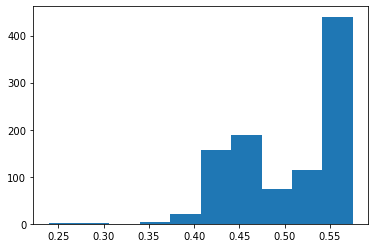

In [15]:
plt.hist(pred_train_probas)

In [ ]:
# plt.plot(active_sampsize, np.array(active_accs).mean(axis=0))

In [50]:
te_sfmx

array([[0.85518387, 0.14481613],
       [0.86651395, 0.13348605],
       [0.87318971, 0.12681029],
       ...,
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

In [33]:
len(selected_inds)

2000